# Import the dataset
Initial import of the dataset to inspect its content and divide it into the basic components (training and test sets).

In [1]:
import numpy as np
import matplotlib as mpl
import albumentations as A
import cv2
import tensorflow as tf


# Setting seeds for reproducibility
np.random.seed(20)

In [2]:
# Load the NpzFile
data = np.load("/kaggle/input/initial-ds/Dataset.npz")

# Inspect content of the NpzFile: contains two keys "training_set", "test_set"
print(data.keys())

# Extract training_set and test_set
training_set = data.get("training_set")
test_set = data.get("test_set")

# Print the shapes of both sets
print(f"The shape of the training set: {training_set.shape}")
print(f"The shape of the test set: {test_set.shape}")

# Split training set into input images and masks
input_images = training_set[:, 0, :, :]
output_masks = training_set[:, 1, :, :]

# Analyse the values of the grayscale images in the training set
print("---------------------------------------------------")
print("TRAINING SET INPUT IMAGES ANALYSIS")
print(f"The shape of the input images: {input_images.shape}")
print(f"Max pixel value: {input_images.max()}")
print(f"Min pixel value: {input_images.min()}")
print(f"Data type to encode pixel values: {input_images.dtype}")

# Analyse the values of the masks in the training set
print("---------------------------------------------------")
print("TRAINING SET OUTPUT MASKS ANALYSIS")
print(f"The shape of the output masks: {output_masks.shape}")
print(f"Max pixel value: {output_masks.max()}")
print(f"Min pixel value: {output_masks.min()}")
print(f"Data type to encode pixel values: {output_masks.dtype}")

# Analyse the values of the grayscale images in the test set
print("---------------------------------------------------")
print("TEST SET ANALYSIS")
print(f"Max pixel value: {test_set.max()}")
print(f"Min pixel value: {test_set.min()}")
print(f"Data type to encode pixel values: {test_set.dtype}")


KeysView(NpzFile '/kaggle/input/initial-ds/Dataset.npz' with keys: training_set, test_set)
The shape of the training set: (2615, 2, 64, 128)
The shape of the test set: (10022, 64, 128)
---------------------------------------------------
TRAINING SET INPUT IMAGES ANALYSIS
The shape of the input images: (2615, 64, 128)
Max pixel value: 254.0
Min pixel value: 2.0
Data type to encode pixel values: float64
---------------------------------------------------
TRAINING SET OUTPUT MASKS ANALYSIS
The shape of the output masks: (2615, 64, 128)
Max pixel value: 4.0
Min pixel value: 0.0
Data type to encode pixel values: float64
---------------------------------------------------
TEST SET ANALYSIS
Max pixel value: 255
Min pixel value: 1
Data type to encode pixel values: uint8


It is possible to notice from this initial analysis that the images have the following characteristics:

- The input images are floating point values ranging between 0 and 255 (full range, not rescaled)
- The output masks are floating point values ranging between 0 and 4 (there are 4 classes)
- The test set uses integer values instead of floats, again in the range 0 to 255

The number of samples in the training set also motivates the need for augmentation techniques, as the input images are quite limited (2615).

Since the images are in the range [0, 255], let's cast them to integer values. The same applied for masks.

In [3]:
input_images = input_images.astype(np.uint8)
output_masks = output_masks.astype(np.uint8)

# Visualisation of some images of the training set

Visualising a good amount of images from the training set can help extracting better insights into the problem to be solved.

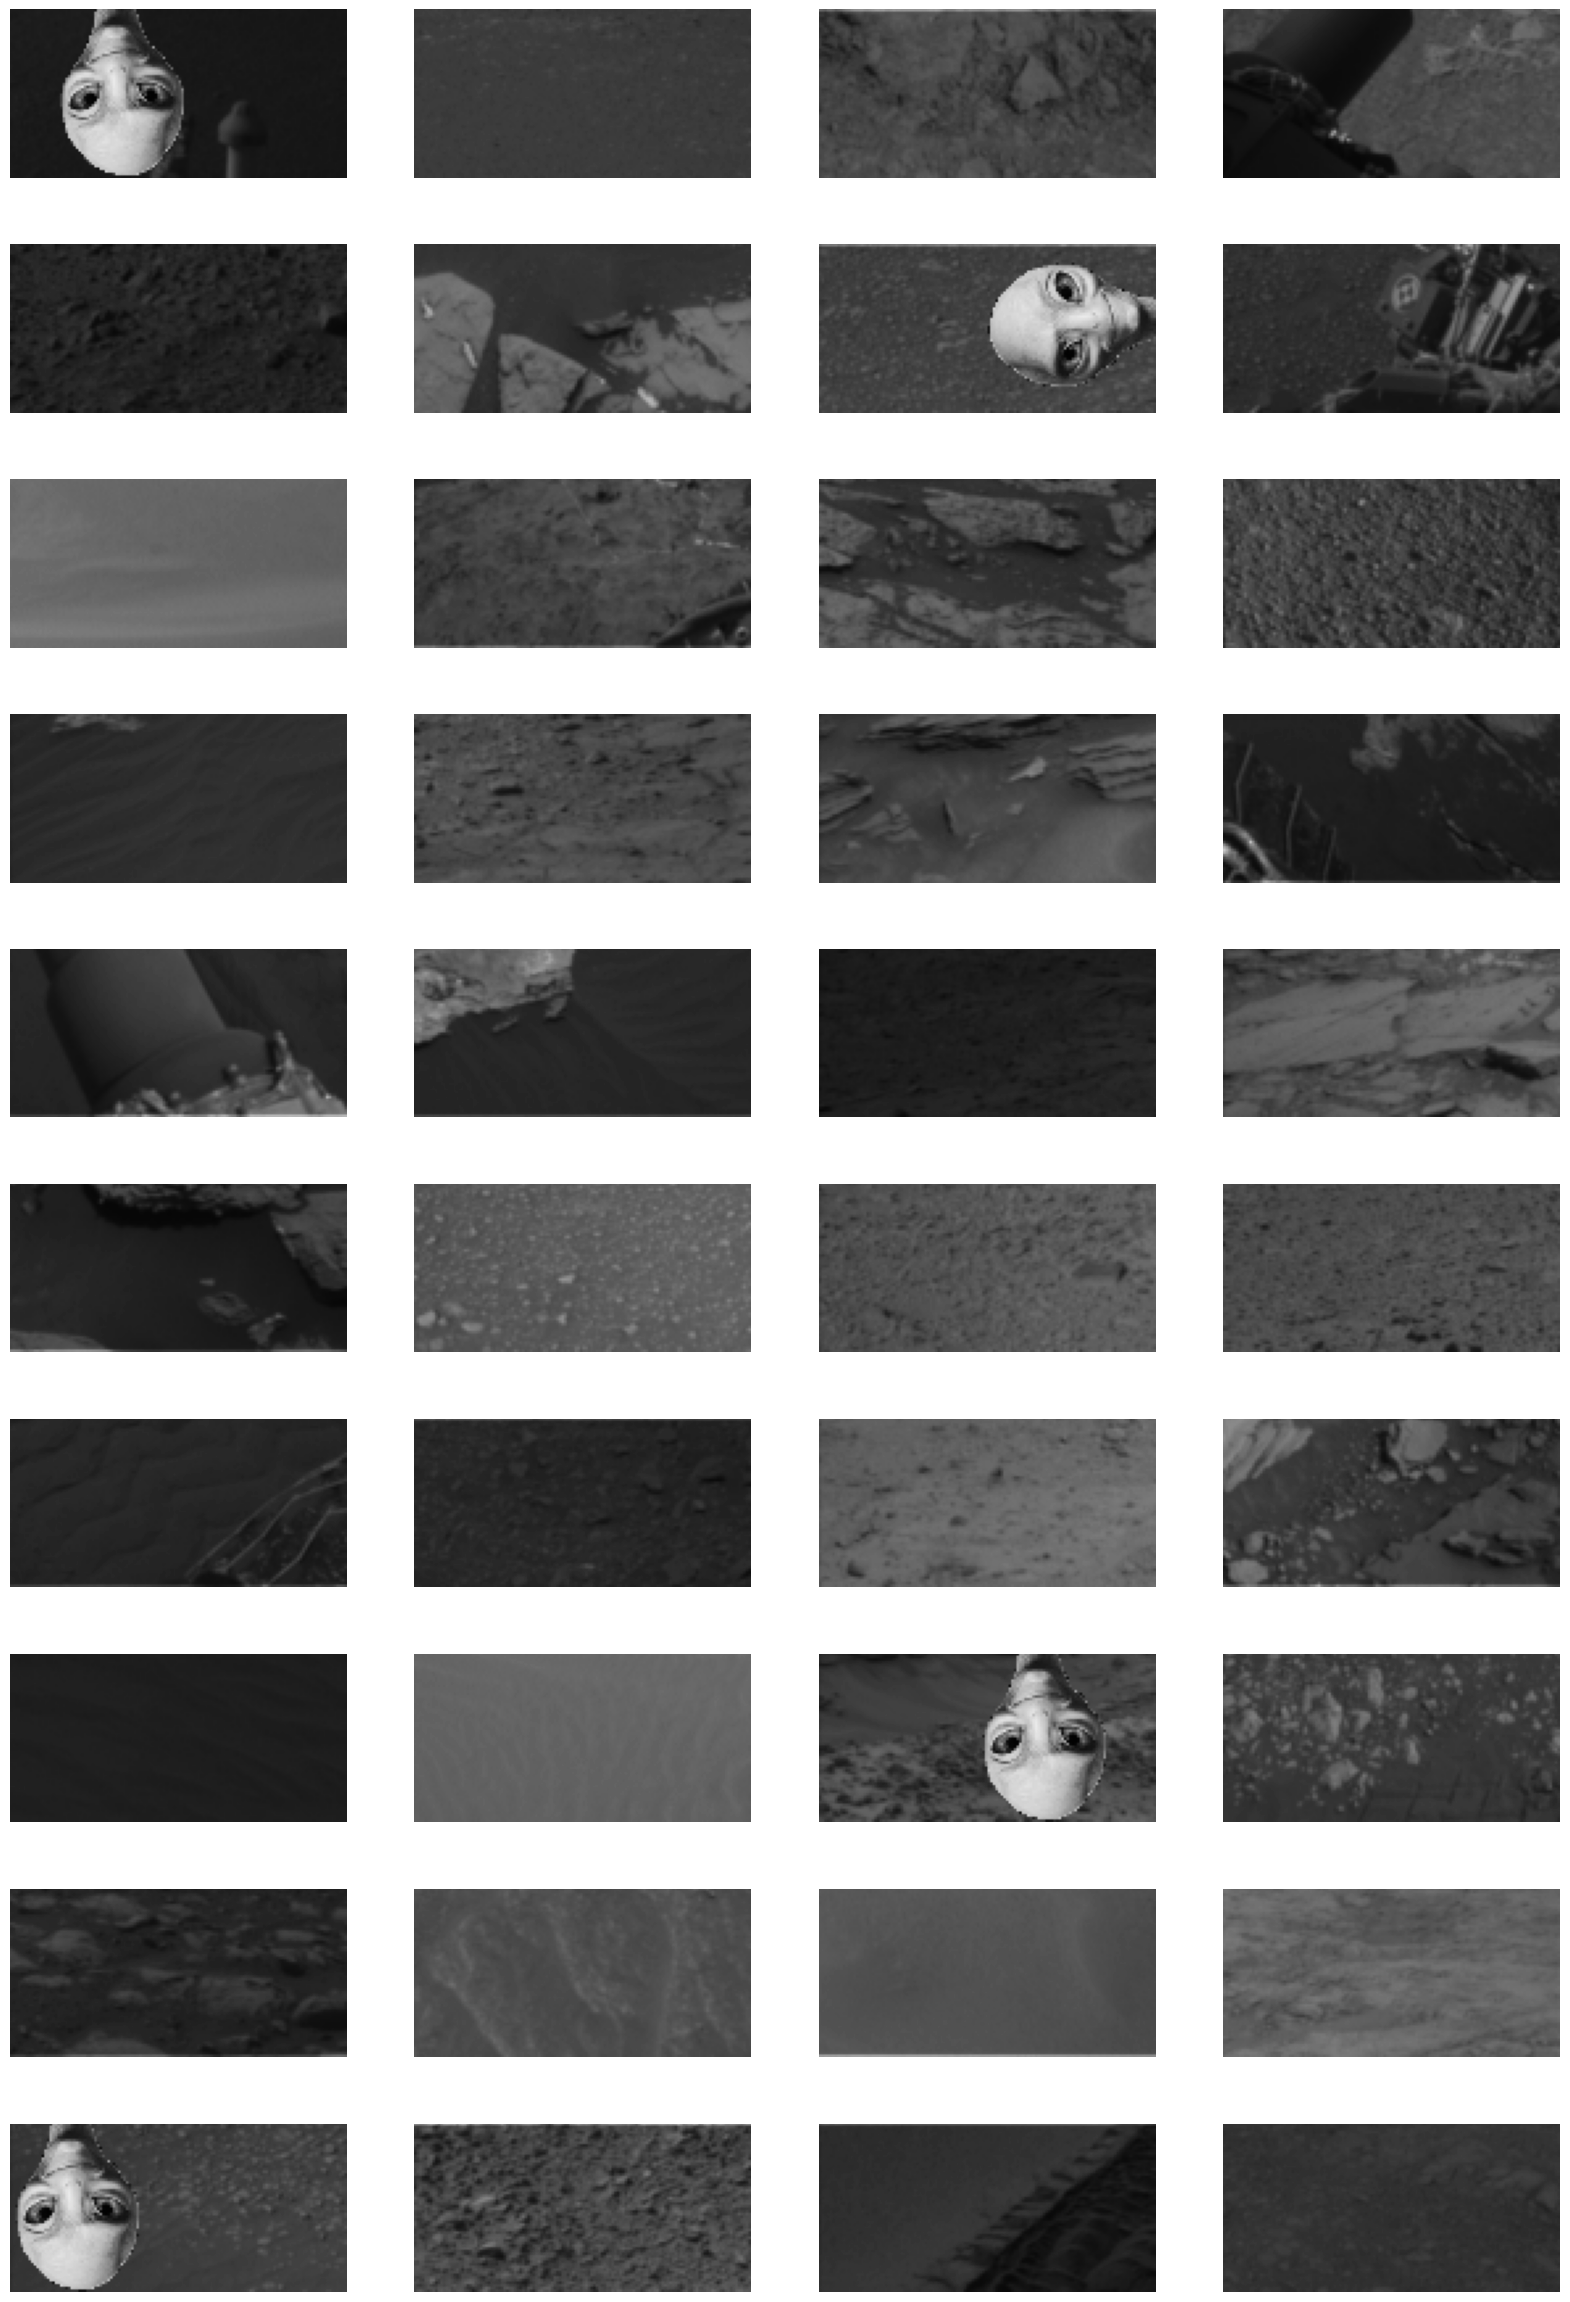

In [4]:
# Generate a new figure object
figure = mpl.pyplot.figure(figsize=(20,30))

# Create 40 subplots within the figure in a grid 10 x 4 (and flatten the Axes array)
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# Select at random 40 images from the training set and show them
random_indices = np.random.randint(0, 2614, size=40)  # Generate an array of 40 random integers
for axes, image_index in zip(axes_array, random_indices):
    axes.imshow(input_images[image_index], cmap='gray', vmin=0, vmax = 255)
    axes.axis('off')
    

figure.show()


# Visualisation of image - mask pairs

Now it is also relevant to display what is the relationship between these input images and their related masks. So let's consider again 20 random images and display one next to the other the images with their associated masks.

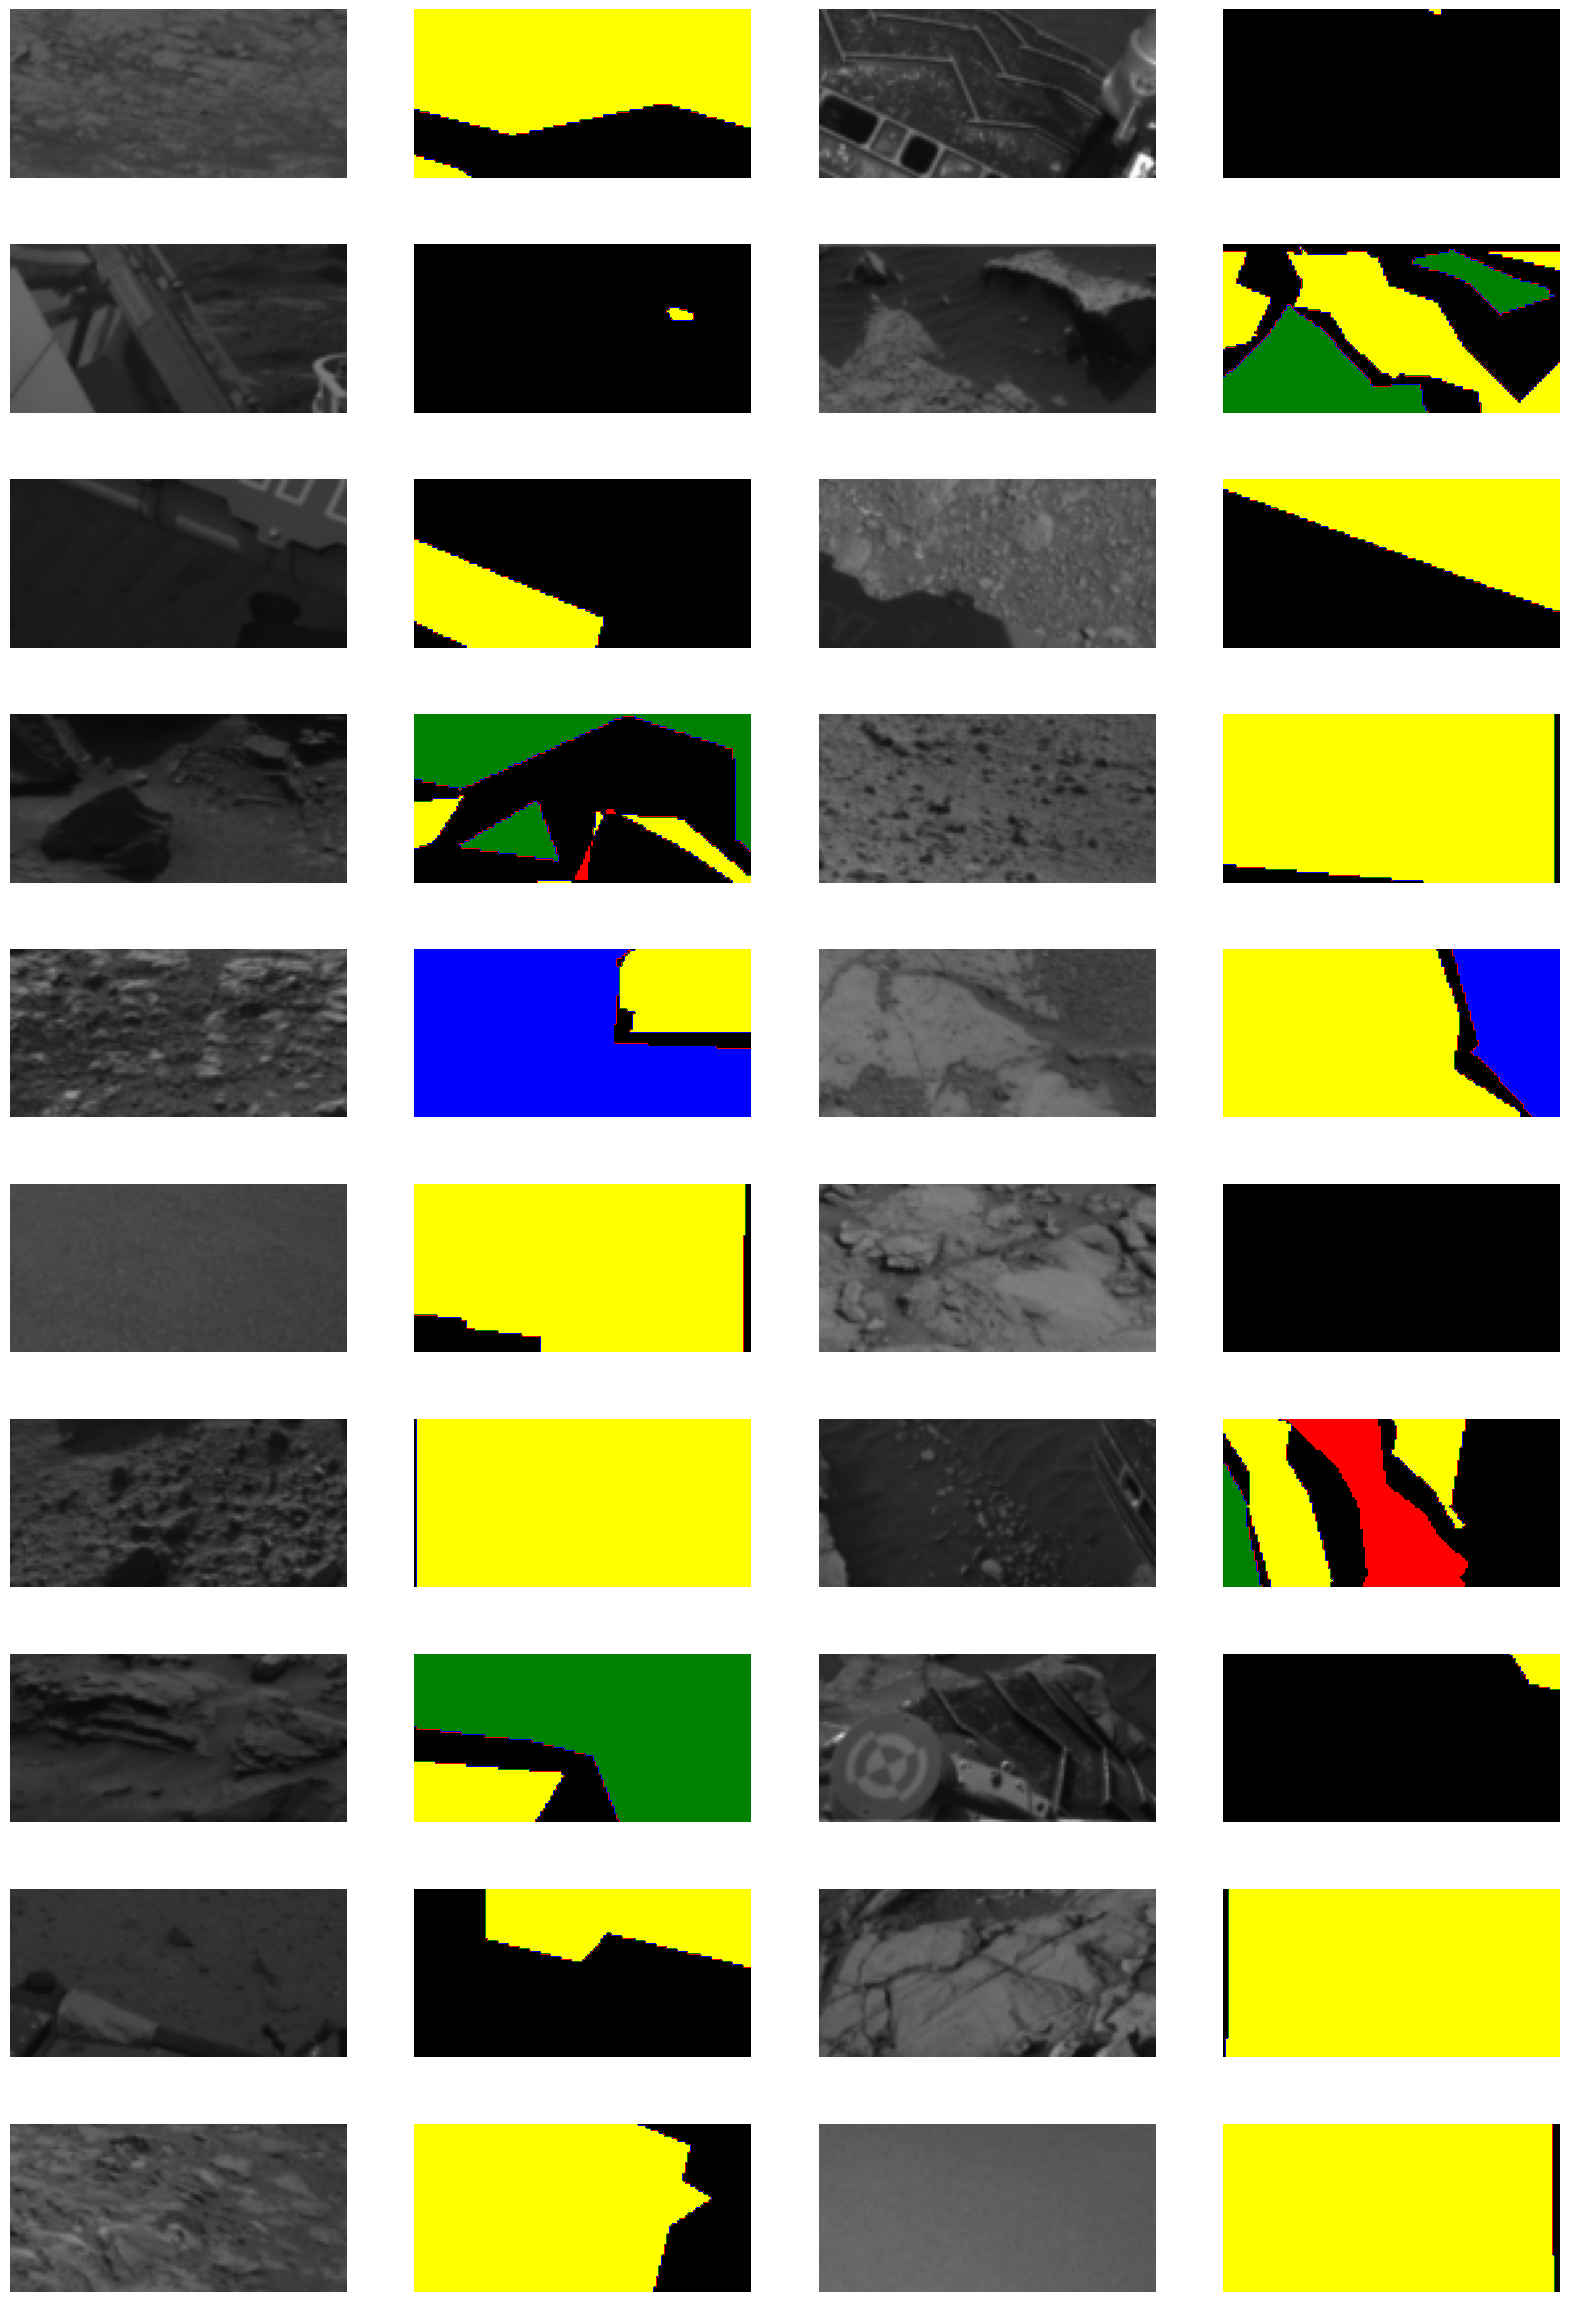

In [5]:
# Define a colormap to simplify the visualisation of the classes on the masks
# Background (0) -> black
# Soil (1) -> red
# Bedrock (2) -> blue
# Sand (3) -> green
# Big Rock (4) -> yellow
colormap = mpl.colors.ListedColormap(["black", "red", "blue", "green", "yellow"])

# Create figure
figure = mpl.pyplot.figure(figsize=(20,30))

# Create axes within the figure in a grid 10 x 4, then flatten the matrix
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# Generate 20 random integers, then display image and mask pairs
random_indices = np.random.randint(0, 2614, size=20)
for index in range(0, 40, 2) :
    axes_array[index].imshow(input_images[index], cmap='gray', vmin=0, vmax=255)
    axes_array[index].axis('off')
    
    axes_array[index + 1].imshow(output_masks[index], cmap=colormap)
    axes_array[index + 1].axis('off')

# Image augmentation

It is necessary to increment the dataset size via augmentation to achieve better generalisation results and mitigate overfitting of the model. 
Let's test some augmentation pipelines offered by the Albumenation library. 

First, define a generic function to plot the results of the transformations.

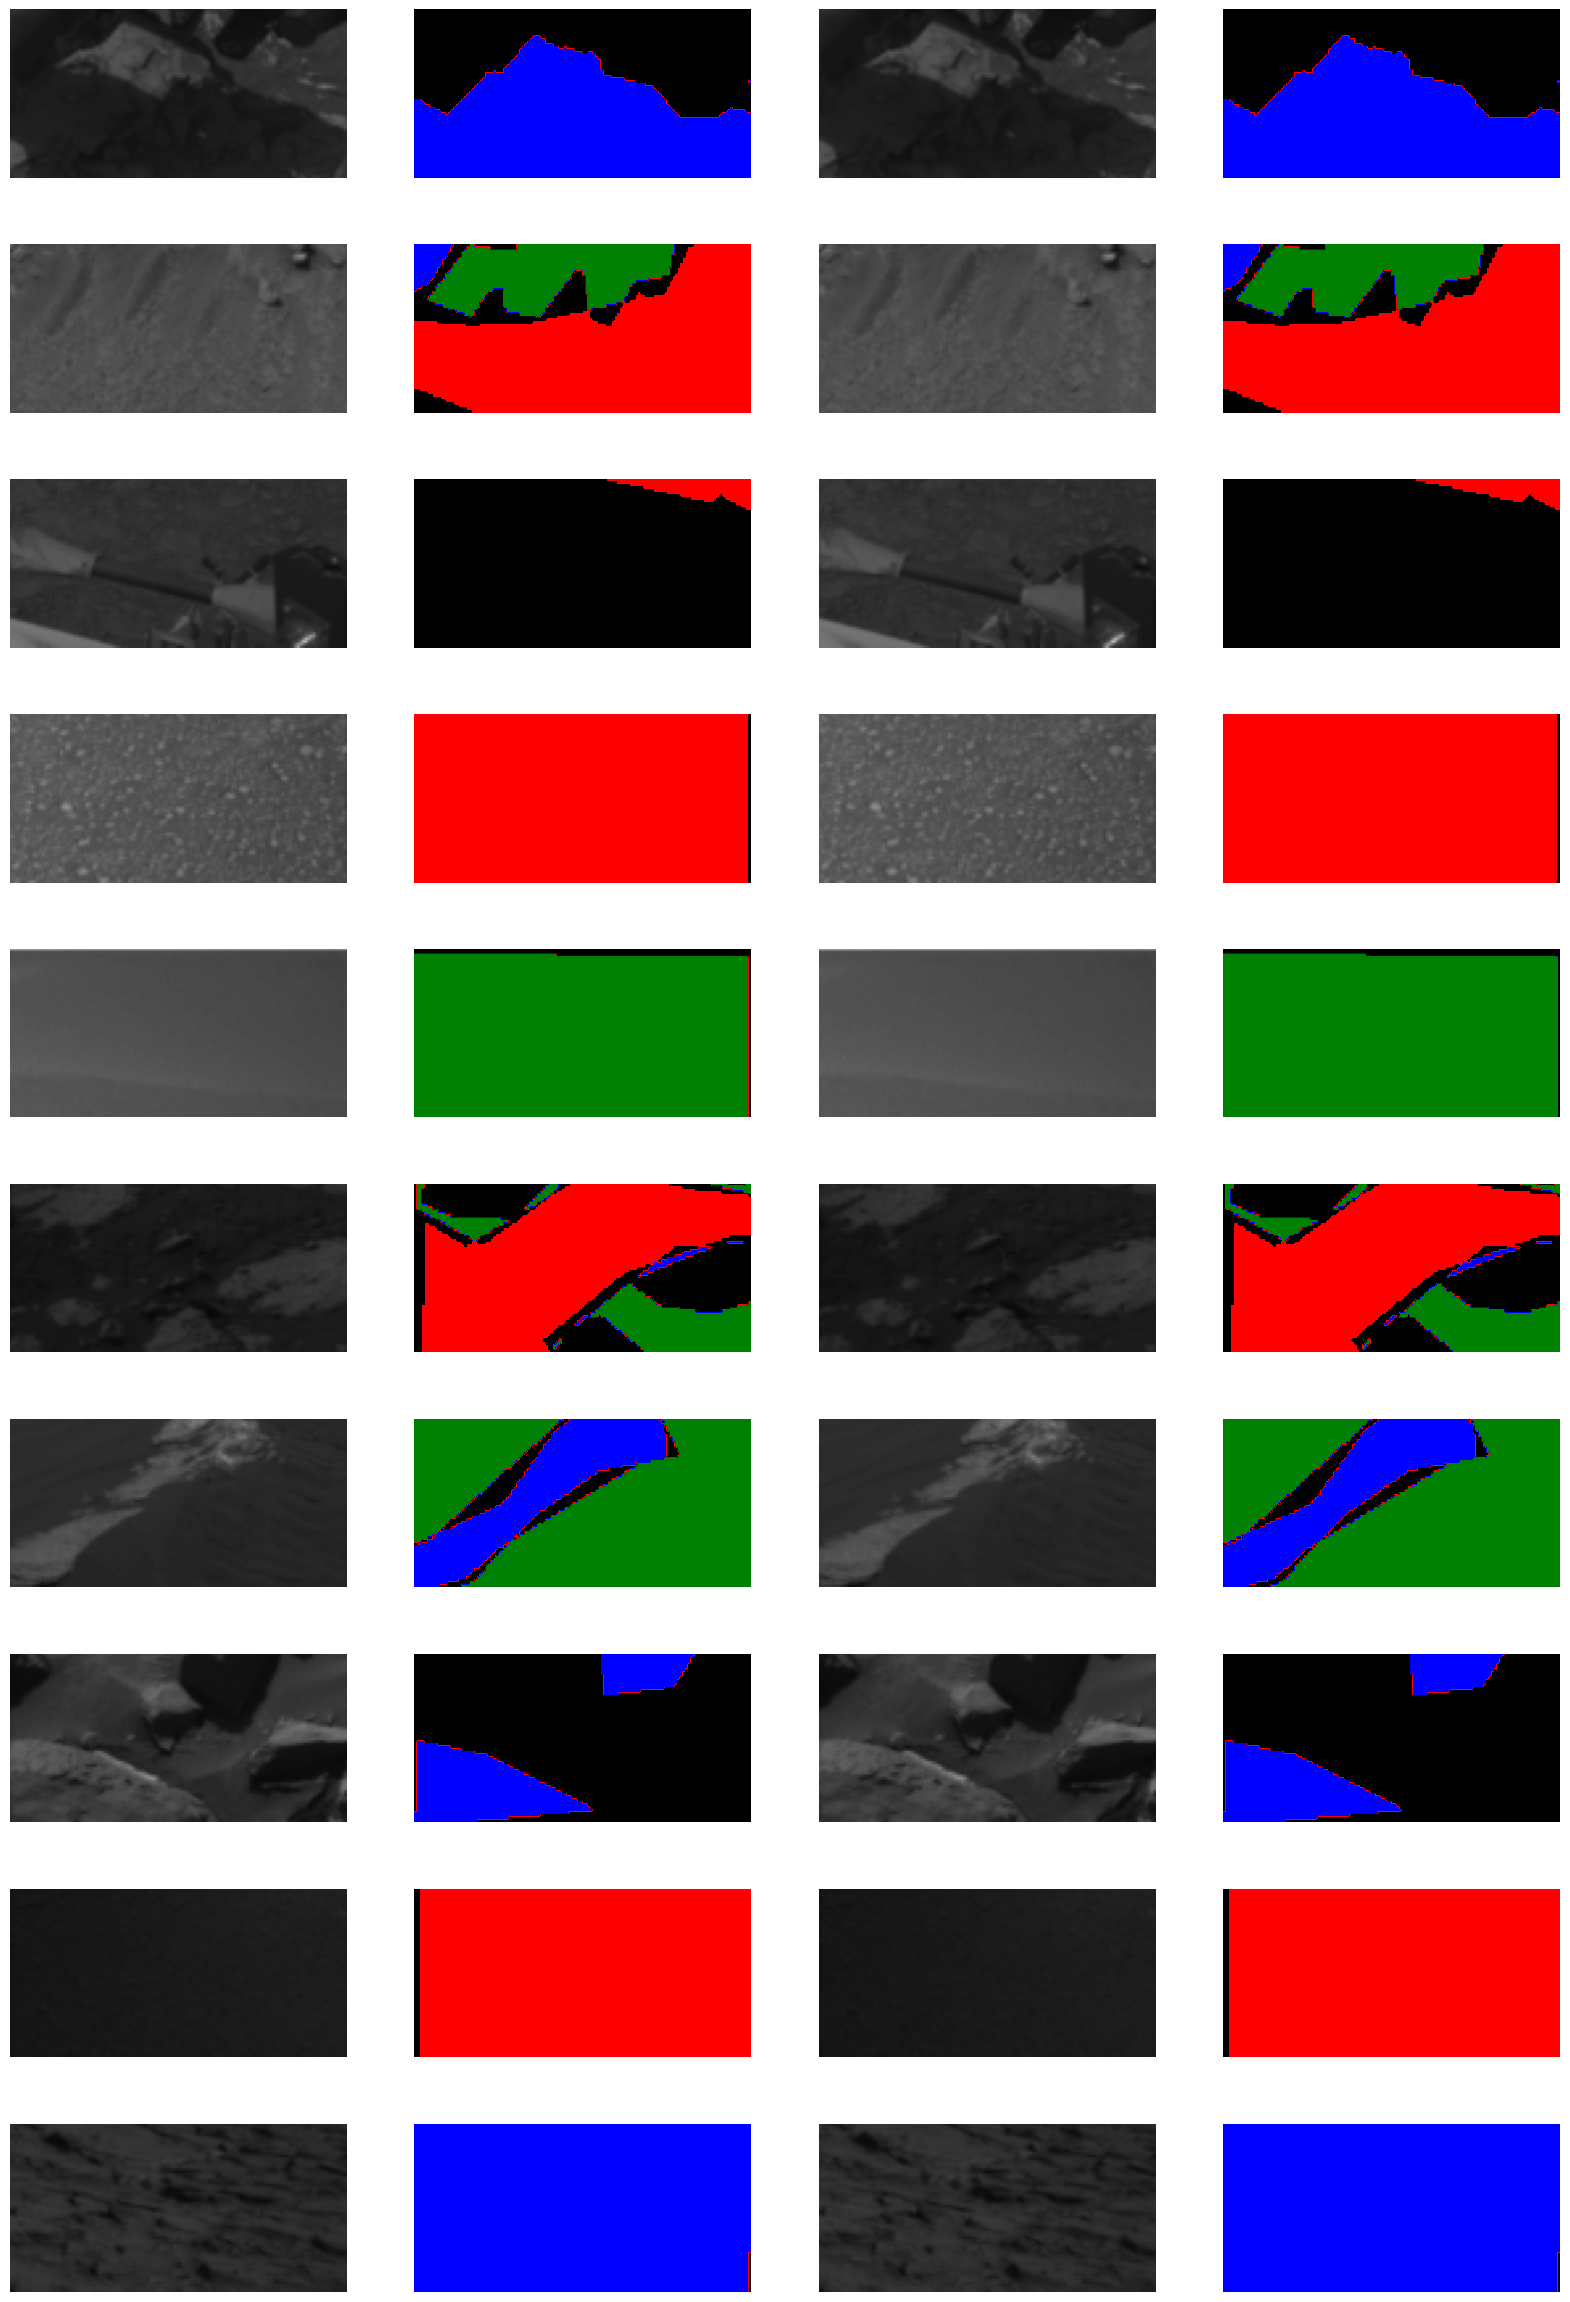

In [6]:

# Extract ten images-mask pairs from the training set
sample_images = input_images[230:240]
sample_masks = output_masks[230:240]

# Define a function to plot images and their corresponding masks
# Notice: when plotting grayscale or masks, it is necessary to specify vmin and vmax to the plotting function
# so that no rescaling is performed on the input data by the library
def plot_images_and_masks(aug_imgs, aug_msks, original_imgs=sample_images, original_msks=sample_masks, grid=(10, 4), figsize=(20, 30), cmap='gray'):

    # Define a colormap to simplify the visualisation of the classes on the masks
    # Background (0) -> black
    # Soil (1) -> red
    # Bedrock (2) -> blue
    # Sand (3) -> green
    # Big Rock (4) -> yellow
    mask_colormap = mpl.colors.ListedColormap(["black", "red", "blue", "green", "yellow"])

    image_count = len(original_imgs)
    
    figure = mpl.pyplot.figure(figsize=figsize)
    axes_array = figure.subplots(grid[0], grid[1])
    axes_array = axes_array.flatten()
    

    for img_index, ax_index  in zip(range(0, image_count), range(0, image_count * 4, 4)):
        # Plot original image
        axes_array[ax_index].imshow(original_imgs[img_index], cmap=cmap, vmin=0, vmax=255)
        axes_array[ax_index].axis('off')
        # Plot original mask
        axes_array[ax_index + 1].imshow(original_msks[img_index], cmap=mask_colormap, vmin=0, vmax=4) 
        axes_array[ax_index + 1].axis('off')
        # Plot augmented image
        axes_array[ax_index + 2].imshow(aug_imgs[img_index], cmap=cmap, vmin=0, vmax=255)
        axes_array[ax_index + 2].axis('off')
        # Plot "augmented" mask
        axes_array[ax_index + 3].imshow(aug_msks[img_index], cmap=mask_colormap, vmin=0, vmax=4) 
        axes_array[ax_index + 3].axis('off')
        
# Test plotting function (these images are a reference to verify the correct functioning of the augmentation techniques)
plot_images_and_masks(sample_images, sample_masks)

## Horizontal flip

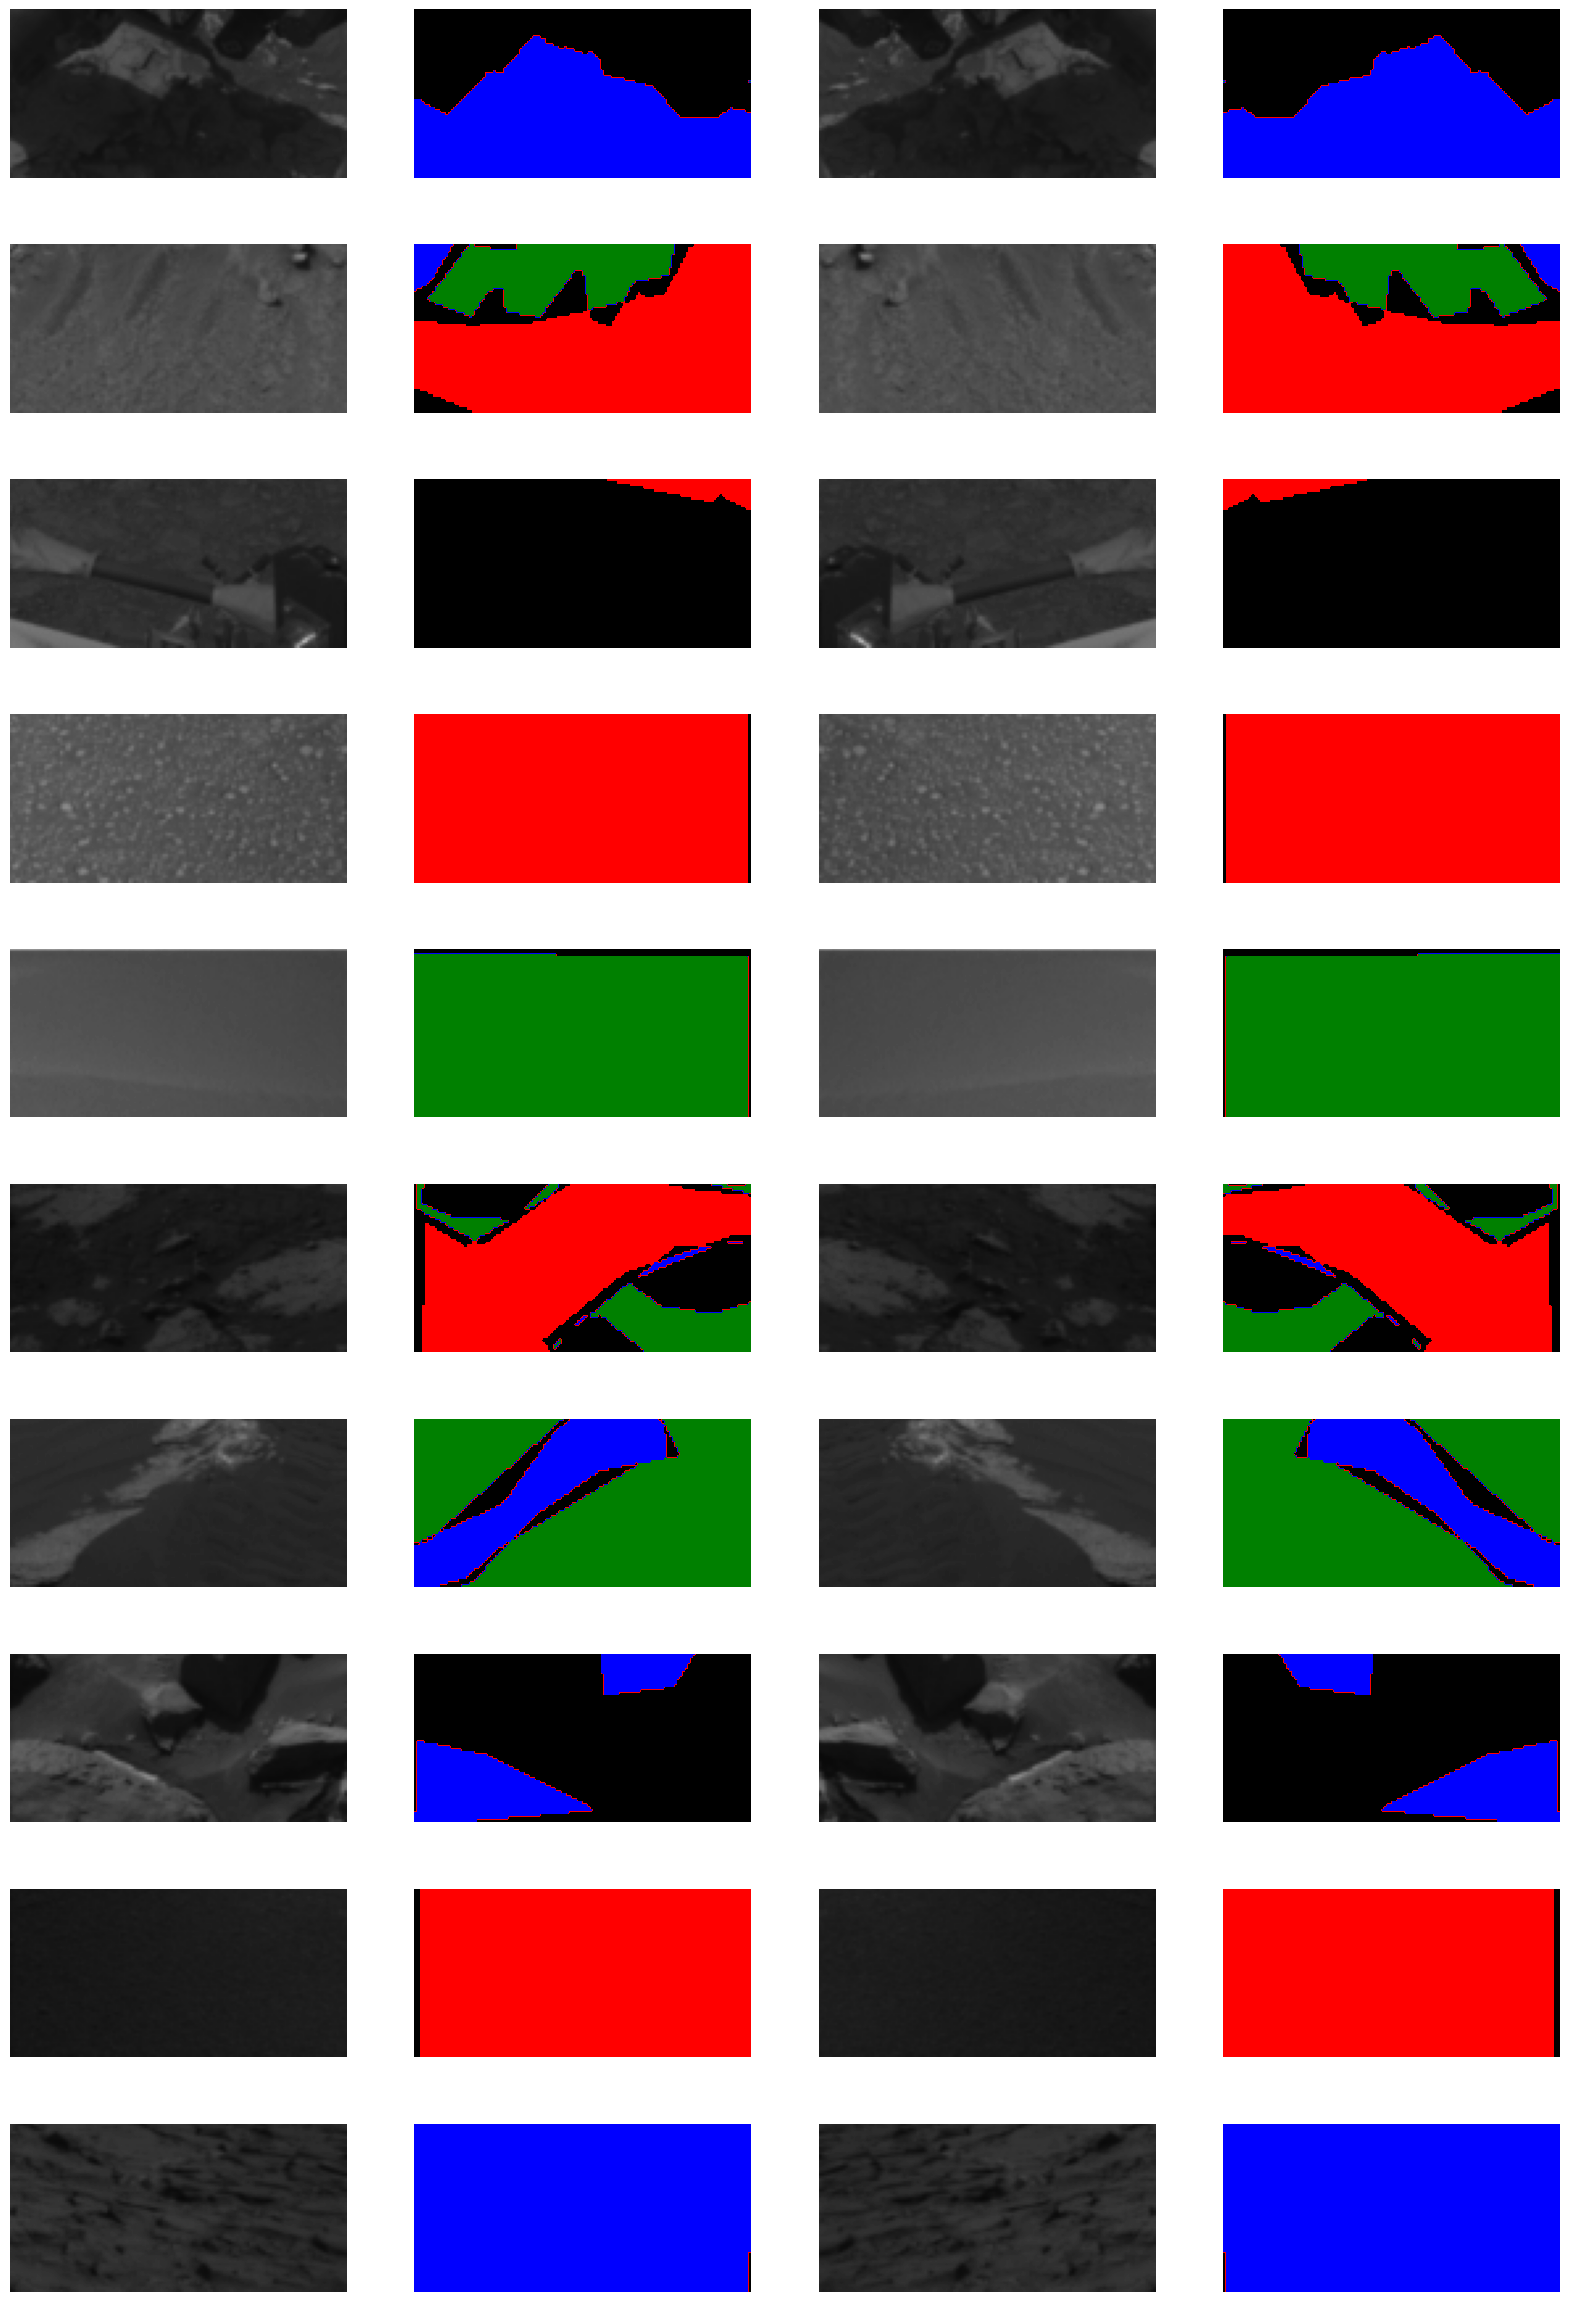

In [7]:
# Create a function to apply HorizontalFlip transformations
def apply_horizontal_flip(images, masks):
    transformation = A.HorizontalFlip(p=1)

    n_images = len(images)
    result_images = np.empty(n_images, dtype=np.ndarray)
    result_masks = np.empty(n_images, dtype=np.ndarray)
    
    for index in range(0, n_images):
        # The application of the transformation returns a dictionary with two keys
        # "image" : modified image
        # "mask" : modified mask
        result_dict = transformation(image=images[index], mask=masks[index])
        result_images[index] = result_dict["image"]
        result_masks[index] = result_dict["mask"]

    return result_images, result_masks
        


flipped_images, flipped_masks = apply_horizontal_flip(sample_images, sample_masks)

plot_images_and_masks(flipped_images, flipped_masks)

## Rotate

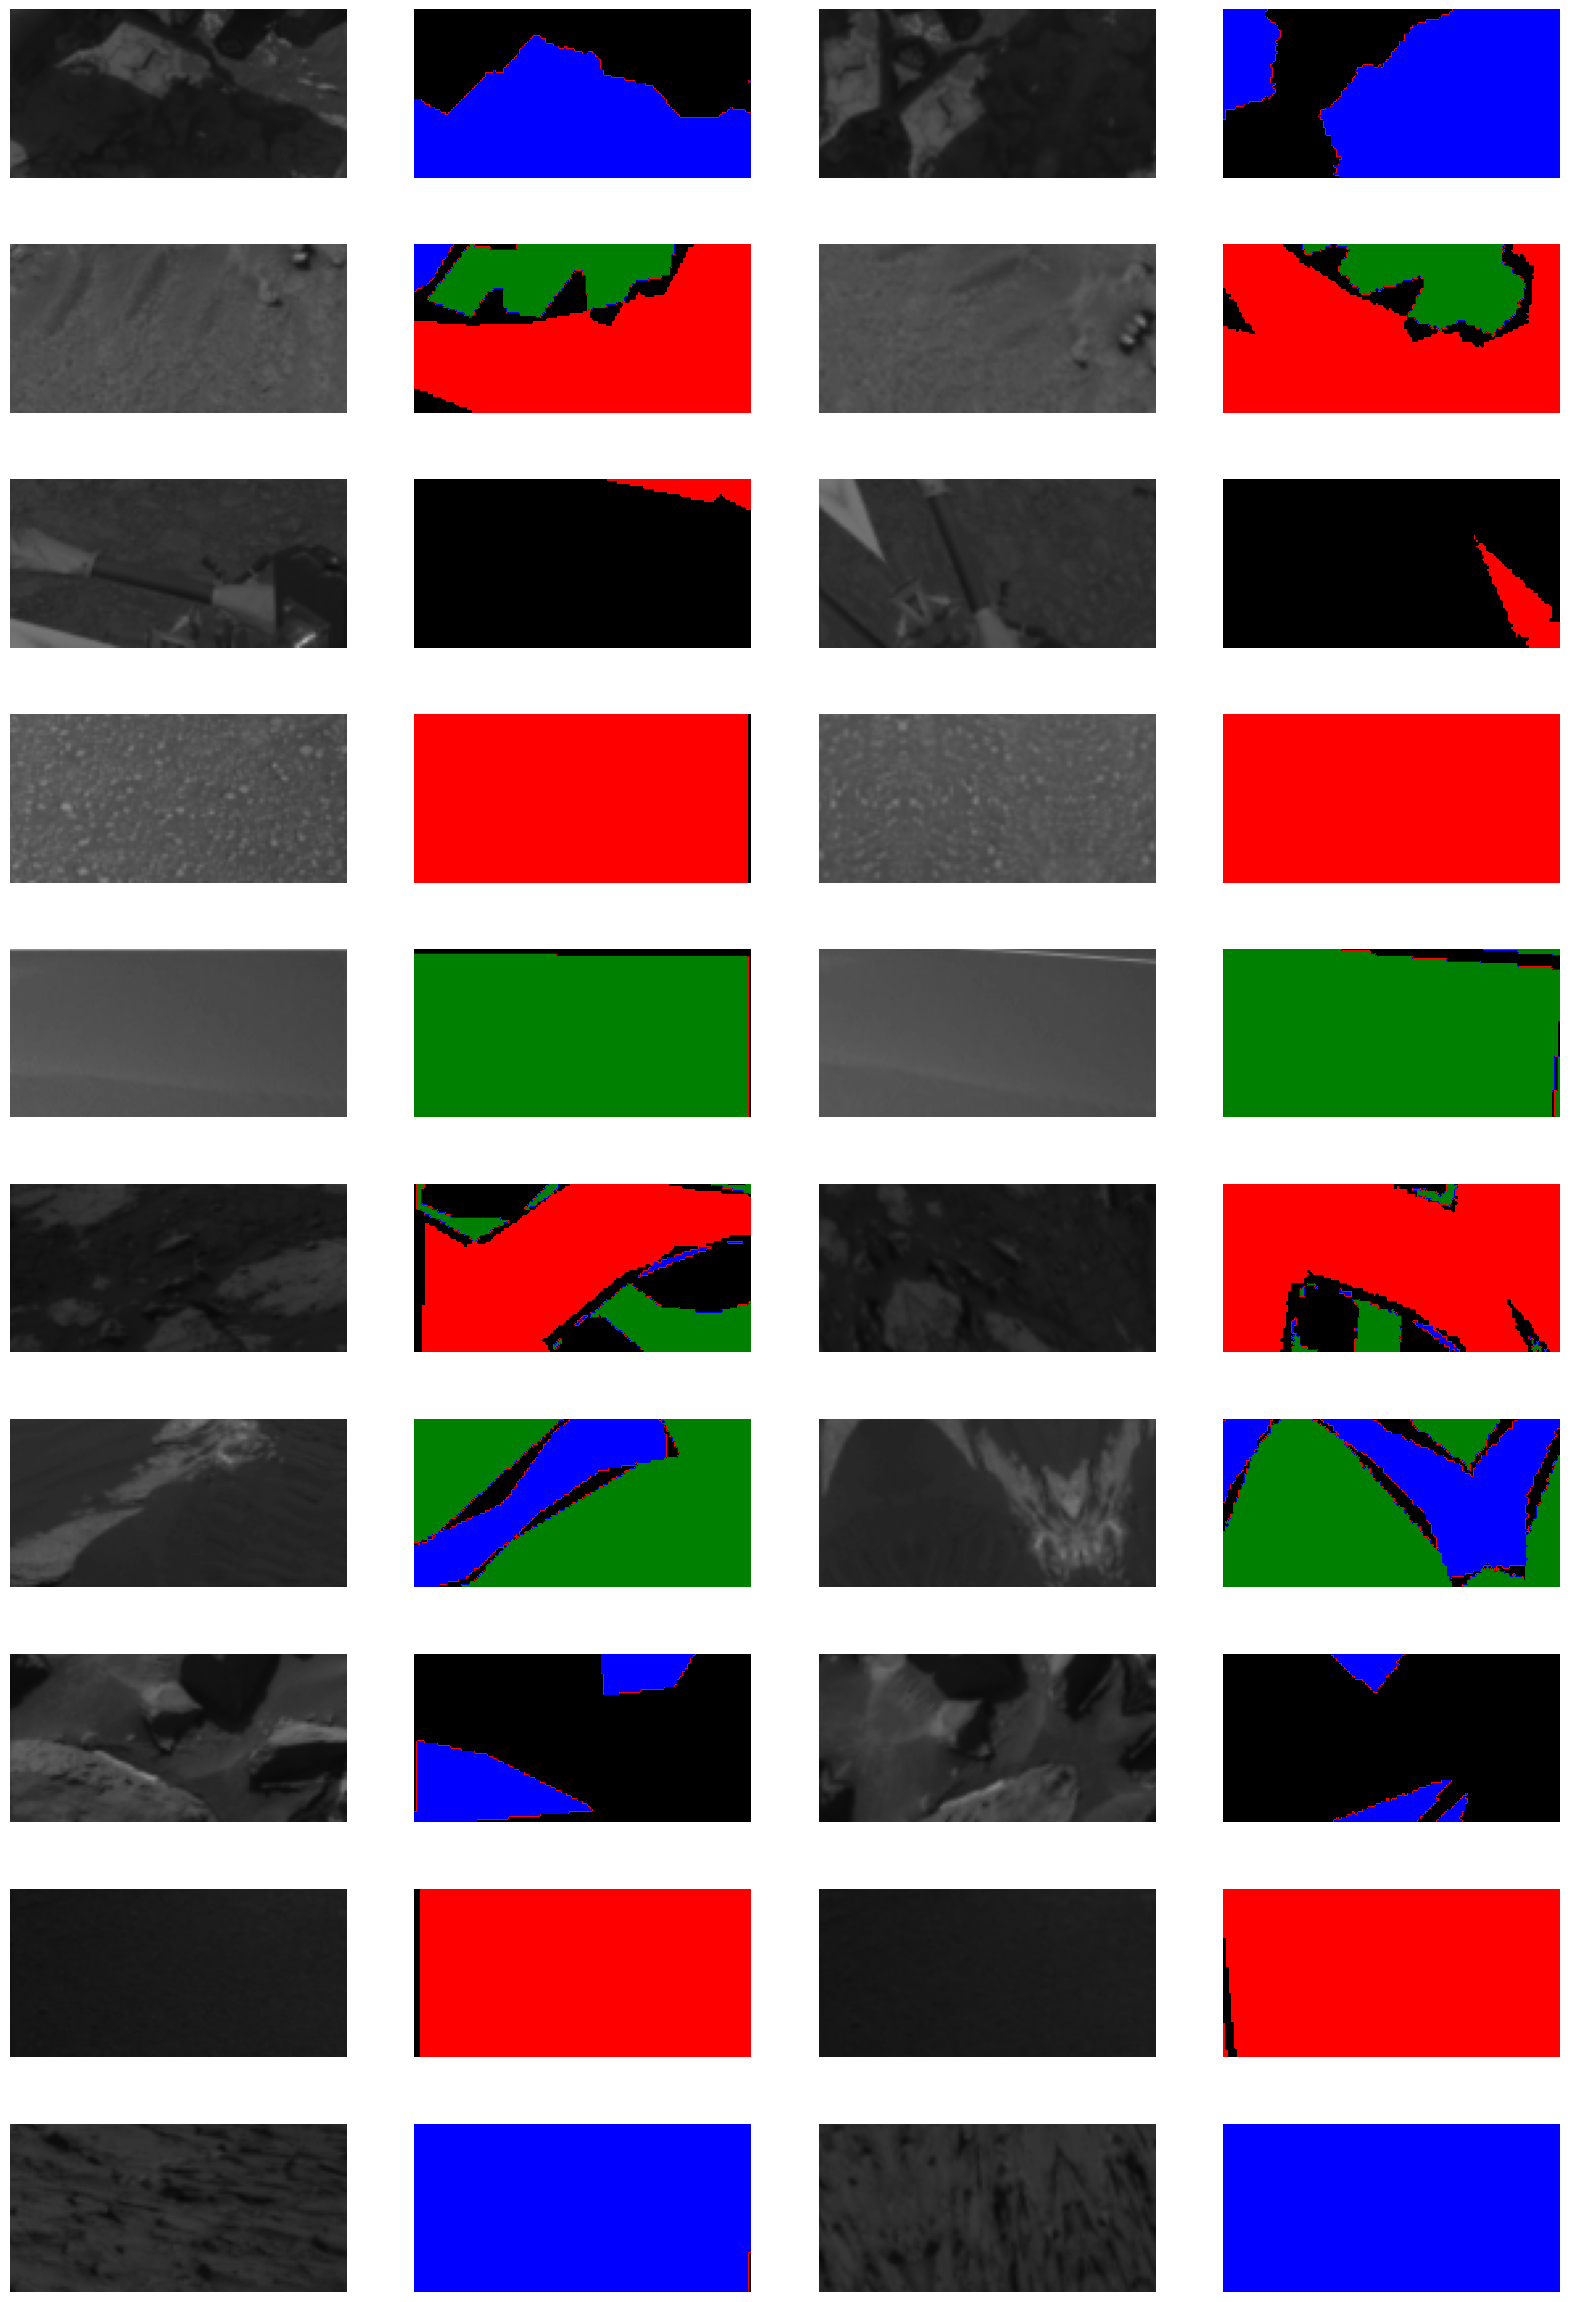

In [8]:
def apply_rotate(images, masks):
    transformation = A.Rotate(p=1)

    n_images = len(images)
    result_images = np.empty(n_images, dtype=np.ndarray)
    result_masks = np.empty(n_images, dtype=np.ndarray)
    
    for index in range(0, n_images):
        # The application of the transformation returns a dictionary with two keys
        # "image" : modified image
        # "mask" : modified mask
        result_dict = transformation(image=images[index], mask=masks[index])
        result_images[index] = result_dict["image"]
        result_masks[index] = result_dict["mask"]

    return result_images, result_masks
        

rotated_images, rotated_masks = apply_rotate(sample_images, sample_masks)

plot_images_and_masks(rotated_images, rotated_masks)

## Complete random pipeline with geometric transformations

Let's build a pipeline for random geometric transformations.

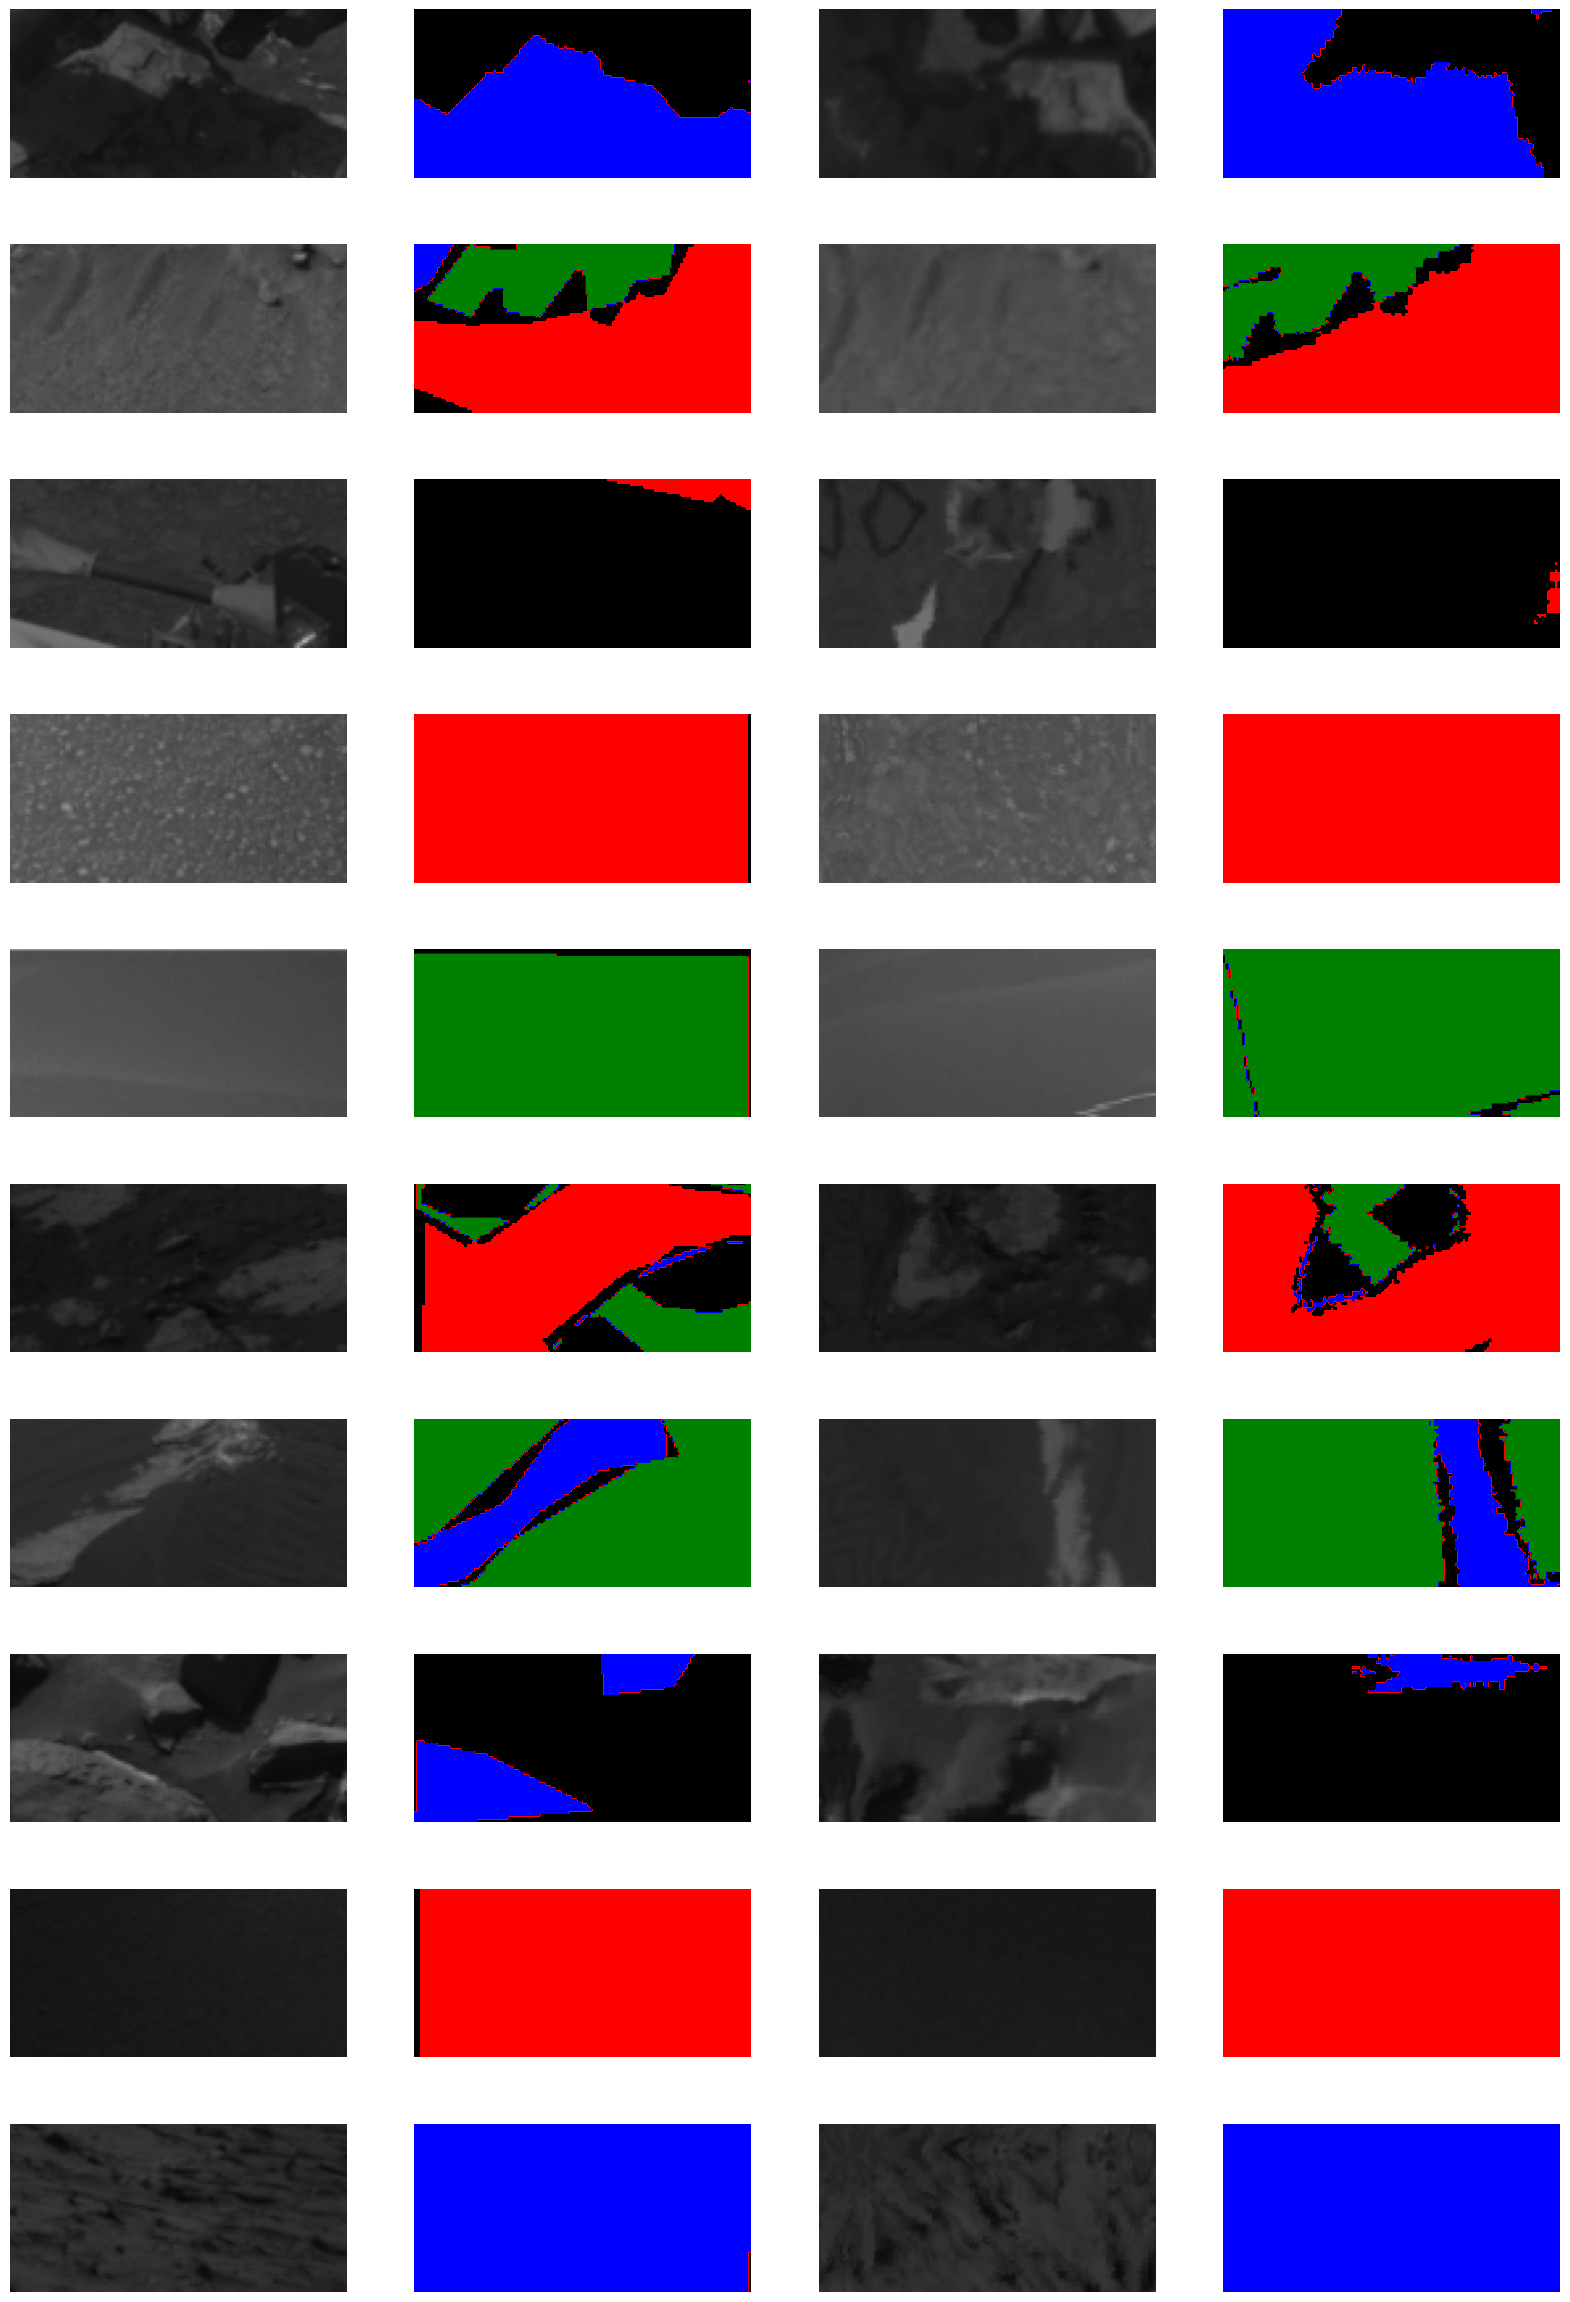

In [9]:
def apply_geometric_transform(images, masks):
    transformation = A.Compose(
        [
            A.Rotate(p=0.9),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, p=0.9),
            A.HorizontalFlip(p=0.7),
            A.VerticalFlip(p=0.7),
            A.ElasticTransform(alpha=10, sigma=10, interpolation=cv2.INTER_NEAREST, p=0.6),   # alpha for distortion level, sigma for smoothness
            A.Perspective(),
            A.GridDistortion()
        ]
    )

    n_images = len(images)
    result_images = np.empty(n_images, dtype=np.ndarray)
    result_masks = np.empty(n_images, dtype=np.ndarray)
    
    for index in range(0, n_images):
        # The application of the transformation returns a dictionary with two keys
        # "image" : modified image
        # "mask" : modified mask
        result_dict = transformation(image=images[index], mask=masks[index])
        result_images[index] = result_dict["image"]
        result_masks[index] = result_dict["mask"]

    return result_images, result_masks
        

augmented_images, augmented_masks = apply_geometric_transform(sample_images, sample_masks)

plot_images_and_masks(augmented_images, augmented_masks)

 ## Intensity transformations

 Let's now consider a pipeline that modifies the intensity of the single grayscale channel of the images.

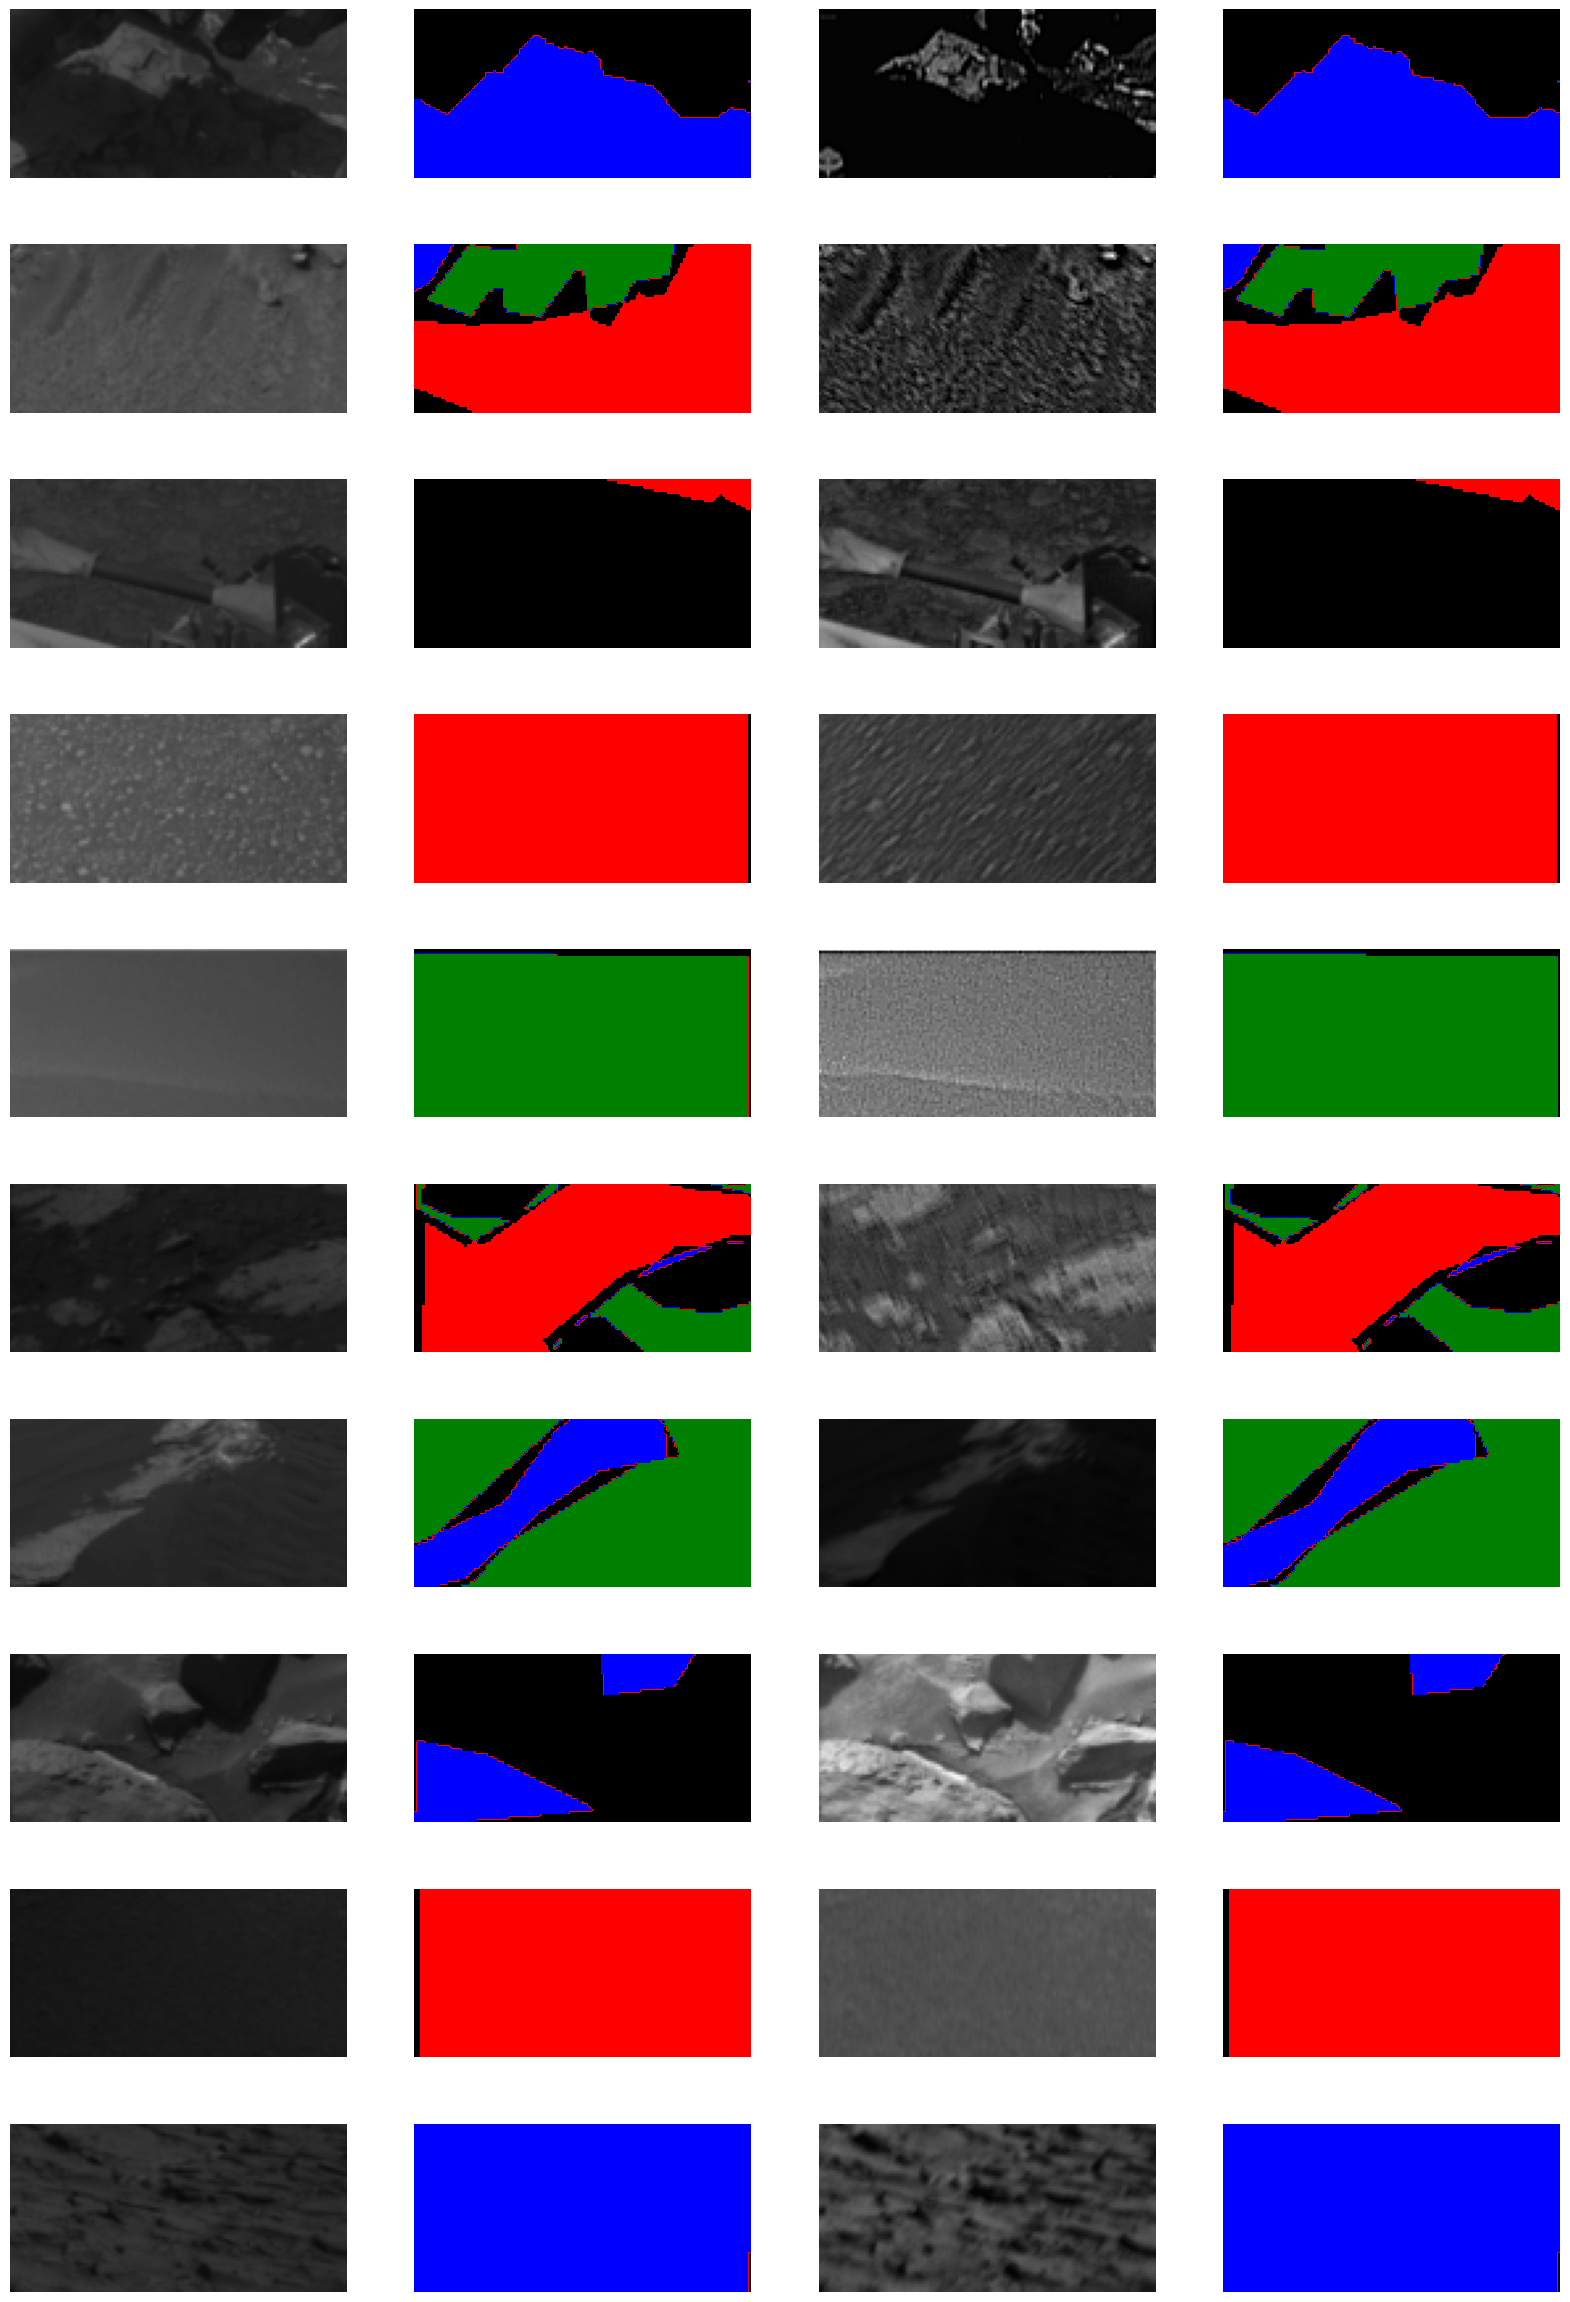

In [10]:
# Notice: for these types of transformations, the library expects the input images in two possible formats:
# floating point values in the range [0.0, 1.0]
# integers in the range [0, 255]
# It is therefore necessary to cast the images to integers before passing them in 
def apply_intensity_transform(images, masks):
    transformation = A.Compose(
        [
            A.RandomBrightnessContrast(p=0.9),
            A.CLAHE(p=0.7),
            A.Sharpen(p=0.5),
            A.MotionBlur(p=0.6),
        ]
    )

    n_images = len(images)
    result_images = np.empty(n_images, dtype=np.ndarray)
    result_masks = np.empty(n_images, dtype=np.ndarray)
    
    for index in range(0, n_images):
        # The application of the transformation returns a dictionary with two keys
        # "image" : modified image
        # "mask" : modified mask
        result_dict = transformation(image=images[index], mask=masks[index])
        result_images[index] = result_dict["image"]
        result_masks[index] = result_dict["mask"]

    return result_images, result_masks
        

augmented_images, augmented_masks = apply_intensity_transform(sample_images, sample_masks)

plot_images_and_masks(augmented_images, augmented_masks)

## Mixing the two pipelines

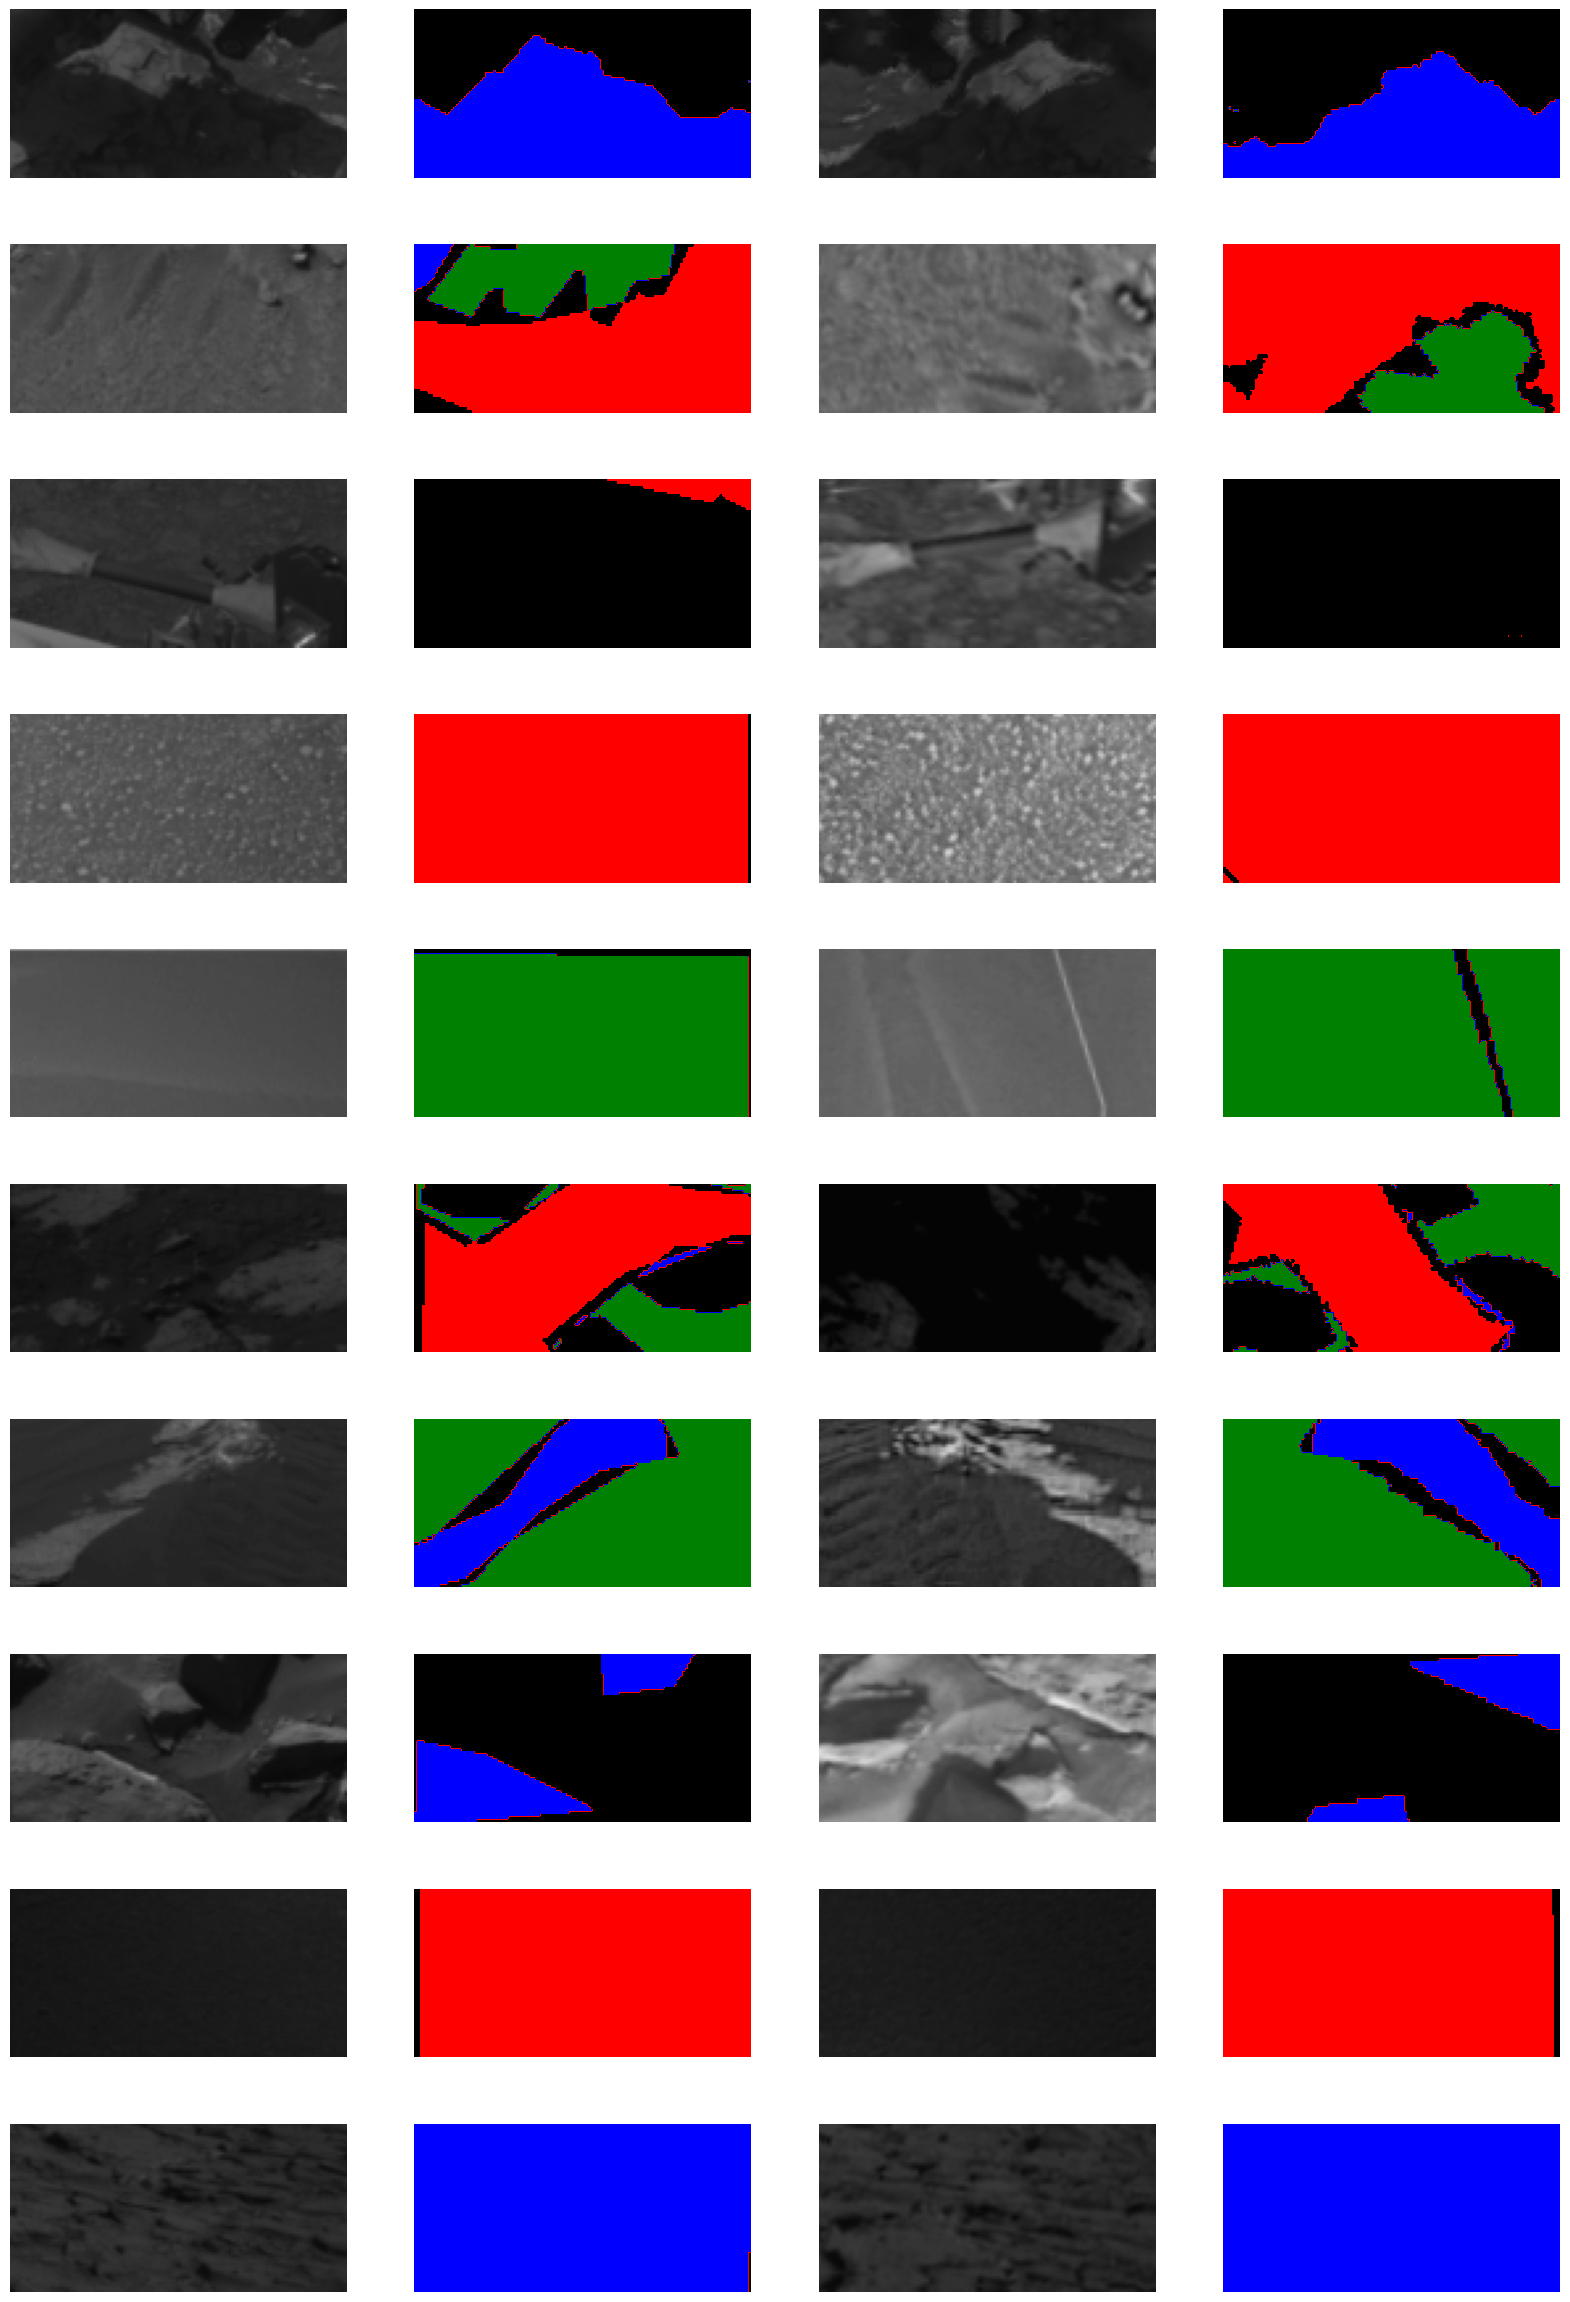

In [11]:
def apply_total_transform(images, masks):
    
    transformation = A.Compose(
        [
            A.SomeOf(
                [
                    A.RandomBrightnessContrast(p=0.5),
                    A.CLAHE(p=0.5, clip_limit=1.1),
                    A.Sharpen(p=0.3, alpha=(0.1,0.25), lightness=(0.9,1)),
                    A.MotionBlur(p=0.4, blur_limit=5)
                ],
                n=2,
                replace=False
            ),
            A.SomeOf(
                [
                    A.Rotate(p=1),
                    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),
                    A.HorizontalFlip(p=1),
                    A.VerticalFlip(p=1),
                    A.ElasticTransform(alpha=5, sigma=5, interpolation=cv2.INTER_NEAREST, p=0.3),   # alpha for distortion level, sigma for smoothness
                    A.Perspective(p=0.3),
                    A.GridDistortion(p=0.3)
                ],
                n=3,
                replace=False 
            ), 
        ]
    )

    n_images = len(images)
    result_images = np.empty(n_images, dtype=np.ndarray)
    result_masks = np.empty(n_images, dtype=np.ndarray)
    
    for index in range(0, n_images):
        # The application of the transformation returns a dictionary with two keys
        # "image" : modified image
        # "mask" : modified mask
        result_dict = transformation(image=images[index], mask=masks[index])
        result_images[index] = result_dict["image"]
        result_masks[index] = result_dict["mask"]

    return result_images, result_masks
        

augmented_images, augmented_masks = apply_total_transform(sample_images, sample_masks)

plot_images_and_masks(augmented_images, augmented_masks)